# atomman.defect.nye_tensor(system, p, theta_max = 27, axes=None, neighbor_list=None, neighbor_list_cutoff=None)

- - -

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.

__Chandler A. Becker__, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), _Office of Data and Informatics, NIST_.

__Zachary T. Trautt__, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), _Materials Measurement Science Division, NIST_.

Version: 2017-01-24

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

The nye_tensor function calculates a per-atom strain and Nye tensor value for every atom within a system. The Nye tensor provides a continuum representation of the local atomic distortion allowing for a means to characterize dislocation core structures. While the results of this calculation are per-atom values, the values take into account all neighbor information and represent continuum-based concepts. Therefore, the results can be transformed into a contour map by interpolating values between points. The Burgers vector of any dislocations present can be identified by numerically integrating a projection of a Nye tensor component over an area encompassing the entire dislocation core.

The algorithm used here follows the one outlined in [Hartley, C. & Mishin, Y. (2005). Acta Materialia 53, 1313-1321.](http://dx.doi.org/10.1016/j.actamat.2004.11.027) and [Hartley, C. S. & Mishin, Y. (2005). Materials Science and Engineering: A 400-401, 18-21.](http://dx.doi.org/10.1016/j.msea.2005.03.076), as well as code obtained from Yuri Mishin. The local atomic environment of each atom is compared to the ideal reference state for that atom, and ideal neighbor vectors, _p_, are paired with corresponding actual neighbor vectors, _q_. A lattice correspondence tensor, __G__, for transforming _q_ to _p_ is obtained for each atom by performing a least-squares optimization on the measured _q_ vectors. Per-atom strains can be obtained directly from the __G__ tensor. Finally, the Nye tensor is evaluated by taking the negative curl of __G__. This is done numerically using the finite-difference approximation.

__Note__ that the equations in the original papers on the atomistic Nye tensor method had a typo with indicies. This function has been verified as producing (nearly) identical results as the actual calculation code used by the authors.    

__Note:__ Calculating the Nye tensor requires a neighbor list for the system. Pre-calculated lists can be given with the neighbor_list argument, or assigned to system.prop['nlist']. Supplying neighbor_list_cutoff calculates the neighbor list only for this function. The suggested neighbor list cutoff for fcc and bcc structures is halfway between the nearest neighbor distance, r1, and next-nearest neighbor distance, r2. 

Arguments:

- __system__ -- a [System](atomman.System.ipynb) to perform the Nye tensor calculation on.

- __p__ -- a list of the reference neighbor vectors for the atoms in the system. This defines the local zero strain state for each atom in the system. If all atoms have the same ideal local neighbor environment (eg. fcc, bcc), then a single list can be supplied that is used by all the atoms. Otherwise, a list is needed for every atom. The function [nye_tensor_p](atomman.defect.nye_tensor_p.ipynb) can help in generating proper lists of p vectors from a base atomic system.

Keyword Arguments:

- __theta_max__ -- maximum angle allowed when matching q neighbor vectors to p ideal neighbor vectors. Suggested values are 27 for fcc and 15 for bcc. Default value is 27. 

- __axes__ -- axes orientiation associated with the system. If supplied, the p neighbor vectors are transformed accordingly. If not given, the p vectors are used as is.
    
- __neighbor_list__ -- pre-computed neighbor list for system. 

- __neighbor_list_cutoff__ -- cutoff for computing a neighbor list for system.

Returns a dictionary containing:

- __strain__ -- the per-atom strain tensor obtained during the calculation. 

- __strain_invariant_1__ -- the per-aton first strain invariant.

- __strain_invariant_2__ -- the per-atom second strain invariant.

- __angular_rotation__ -- the per-atom angular rotation.

- __Nye_tensor__ -- the per-atom Nye tensor.

The underlying code can be found in [atomman/defect/nye_tensor.py](../../atomman/defect/nye_tensor.py).

## Demonstration

Library imports

In [1]:
#Standard libraries
from __future__ import print_function
import time

#http://www.numpy.org/
import numpy as np             

#http://matplotlib.org/
%matplotlib inline

#https://github.com/usnistgov/atomman
import atomman as am 

Load system containing an fcc screw dislocation

In [2]:
system_dump_file = 'files/atomman.defect.nye_tensor/Al-fcc-screw.dump'
system = am.load('atom_dump', system_dump_file)[0]

Specify parameters related to the loaded system

In [3]:
alat = 4.04527

axes = np.array([[-1, 2,-1],
                 [ 1, 1, 1],
                 [ 1, 0,-1]])

Define the ideal neighbor vectors, p, for an fcc system with the associated lattice parameters. Note that these are associated with the cubic orientation and have not been rotated yet, i.e are for the \[100\] \[010\] \[001\] axes orientation. 

In [4]:
p = alat*np.array([[ 0.0, 0.5, 0.5], 
                   [ 0.0,-0.5, 0.5],
                   [ 0.0,-0.5,-0.5],              
                   [ 0.0, 0.5,-0.5],
                   [ 0.5, 0.0, 0.5],
                   [-0.5, 0.0, 0.5],
                   [-0.5, 0.0,-0.5], 
                   [ 0.5, 0.0,-0.5],
                   [ 0.5, 0.5, 0.0],
                   [-0.5, 0.5, 0.0],
                   [-0.5,-0.5, 0.0],
                   [ 0.5,-0.5, 0.0]])

Compute the nearest neighbor list using a cutoff halfway between the first and second neighbor distances.

In [5]:
r = (2**0.5/2 + 1) / 2
system.nlist(alat * r)
print('Average number of neighbors =', np.mean(system.prop['nlist'][:,0]))

Average number of neighbors = 11.8240310078


Perform the nye_tensor calculation supplying p and axes.

In [6]:
nye_results = am.defect.nye_tensor(system, p, axes=axes)

Assign results to the system's per-atom properties

In [7]:
for key, value in nye_results.iteritems():
    system.atoms_prop(key=key, value=value)

Plot

In [8]:
plot_range = np.array([[-15, 15], [-15, 15], [0, alat*2**0.5]])

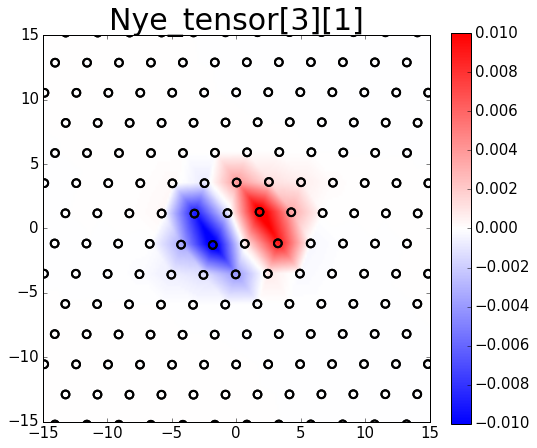

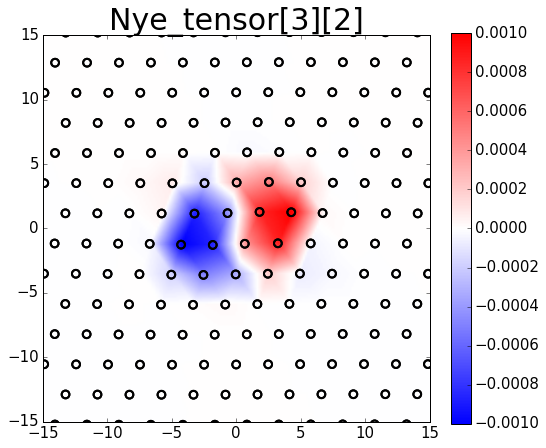

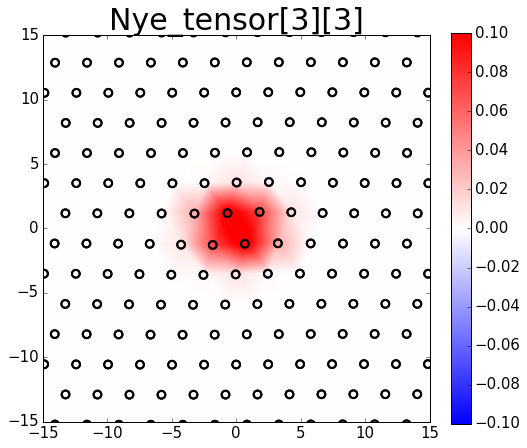

Burgers vector estimate = [ -9.23123333e-09  -3.19797483e-09   2.91540886e+00]


In [9]:
int_sum = np.empty(3)
for i in xrange(3):
    int_sum[i] = am.plot.interpolate_contour(system, 'Nye_tensor', index=[2,i], plotbounds=plot_range, cmap='bwr')[0]
    
print('Burgers vector estimate =', int_sum)

In [10]:
print('Actual Burgers vector =', alat * np.array([0, 0, 2**0.5/2]))

Actual Burgers vector = [ 0.          0.          2.86043785]


__Docs Navigation:__

Tutorial:

1. [Basics](../tutorial/1 Basics.ipynb)

2. [LAMMPS Functionality](../tutorial/2 LAMMPS Functionality.ipynb)

3. [Defect Generation and Evaluation](../tutorial/3 Defect Generation and Evaluation.ipynb)


Reference:

- [atomman](../reference/atomman.ipynb)

- [atomman.convert](../reference/atomman.convert.ipynb)

- [atomman.defect](../reference/atomman.defect.ipynb)

- [atomman.lammps](../reference/atomman.lammps.ipynb)

- [atomman.tools](../reference/atomman.tools.ipynb)

- [atomman.unitconvert](../reference/atomman.unitconvert.ipynb)